# ✈️ Aviation Weather Forecasting: Managing Volatility & Risk

## Executive Summary
A robust machine learning model to predict daily weather conditions (Min and Max Temperatures) to assist in flight planning and safety assessments at JFK Airport.

**Key Findings & Methodologies:**
1.  **Business Logic Integration:** Incorporated raw weather codes (Fog, Thunder, Snow) to create a "Flight Suitability" classification, moving beyond simple temperature prediction.
2.  **Risk Analysis (Heteroscedasticity):** Statistical testing (Breusch-Pagan, $p < 0.01$) revealed that weather volatility is **not constant**—it has increased over decades and exhibits strong **seasonal heteroscedasticity** (Winter is significantly harder to predict than Summer).
3.  **Advanced Modeling:** Switched from standard regression to **Quantile XGBoost**. Instead of a single point prediction, the model outputs a **90% Confidence Interval ("Risk Tunnel")**, allowing for dynamic safety margins that adapt to the increased volatility of winter months.

**Tech Stack:** Python, Pandas, XGBoost (Quantile Regression), Scikit-Learn, Optuna, Statsmodels.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import optuna
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

In [2]:
df = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])

# CRITICAL: Fill NaN in 'WT' columns with 0 (NaN means "event didn't happen")
wt_cols = [c for c in df.columns if 'WT' in c]
df[wt_cols] = df[wt_cols].fillna(0)

# 2. Impute core weather numeric NaNs with previous values (Forward Fill)
core_cols = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']
df[core_cols] = df[core_cols].ffill()

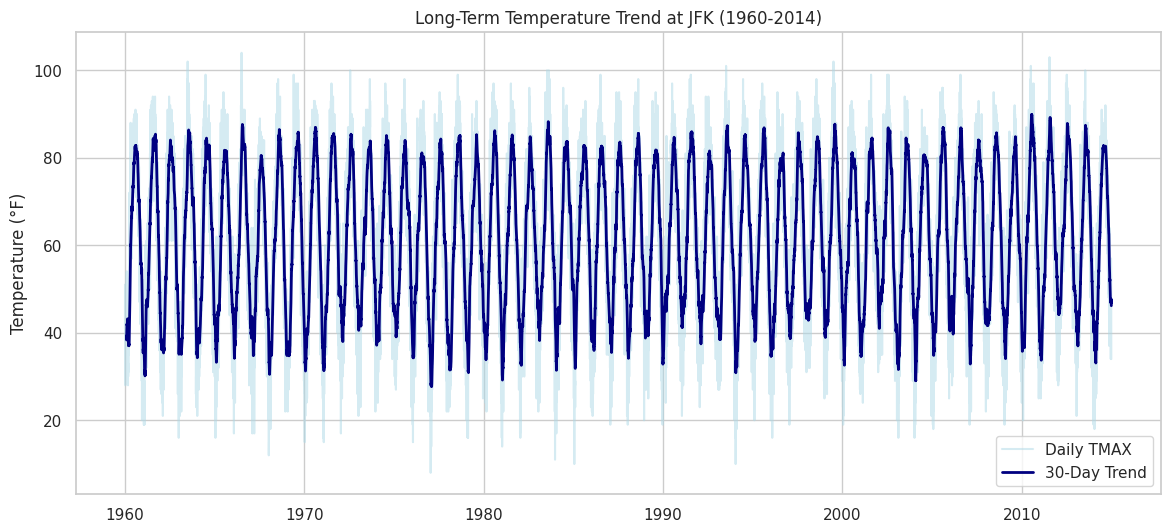

In [3]:
# Set the visual style
sns.set(style="whitegrid")

# This smooths out the daily noise so we can see the "climate"
rolling_mean = df['TMAX'].rolling(window=30).mean()

plt.figure(figsize=(14, 6))

# Plot 1: Raw Daily Data (Light and noisy)
plt.plot(df['DATE'], df['TMAX'], label='Daily TMAX', color='lightblue', alpha=0.5)

# Plot 2: The Trend (Smooth)
plt.plot(df['DATE'], rolling_mean, label='30-Day Trend', color='navy', linewidth=2)

plt.title('Long-Term Temperature Trend at JFK (1960-2014)')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.show()

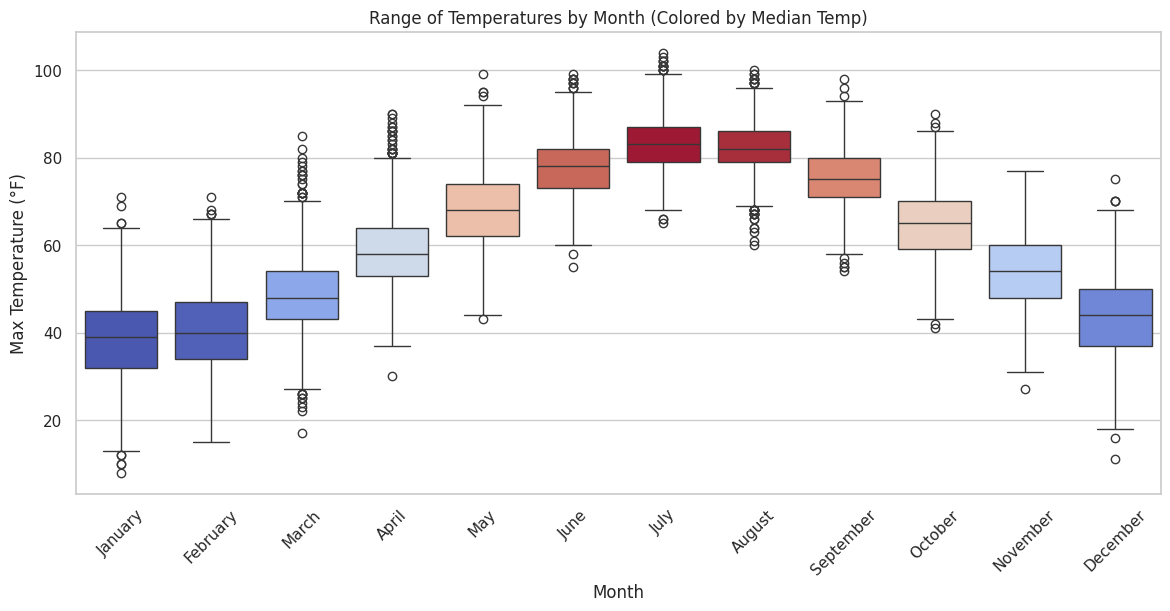

In [4]:
# Extract Month Name for labeling
df['month_name'] = df['DATE'].dt.month_name()

# Define the correct order for the plot (otherwise it sorts them alphabetically)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']


monthly_median = df.groupby('month_name')['TMAX'].median().reindex(month_order)

# Create a color mapper and boxplot
norm = mcolors.Normalize(vmin=monthly_median.min(), vmax=monthly_median.max())
palette_colors = list(cm.coolwarm(norm(monthly_median.values)))

plt.figure(figsize=(14, 6))
sns.boxplot(
    x='month_name', 
    y='TMAX', 
    data=df, 
    order=month_order, 
    palette=palette_colors, 
    hue='month_name', 
    legend=False
)

plt.title('Range of Temperatures by Month (Colored by Median Temp)')
plt.ylabel('Max Temperature (°F)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

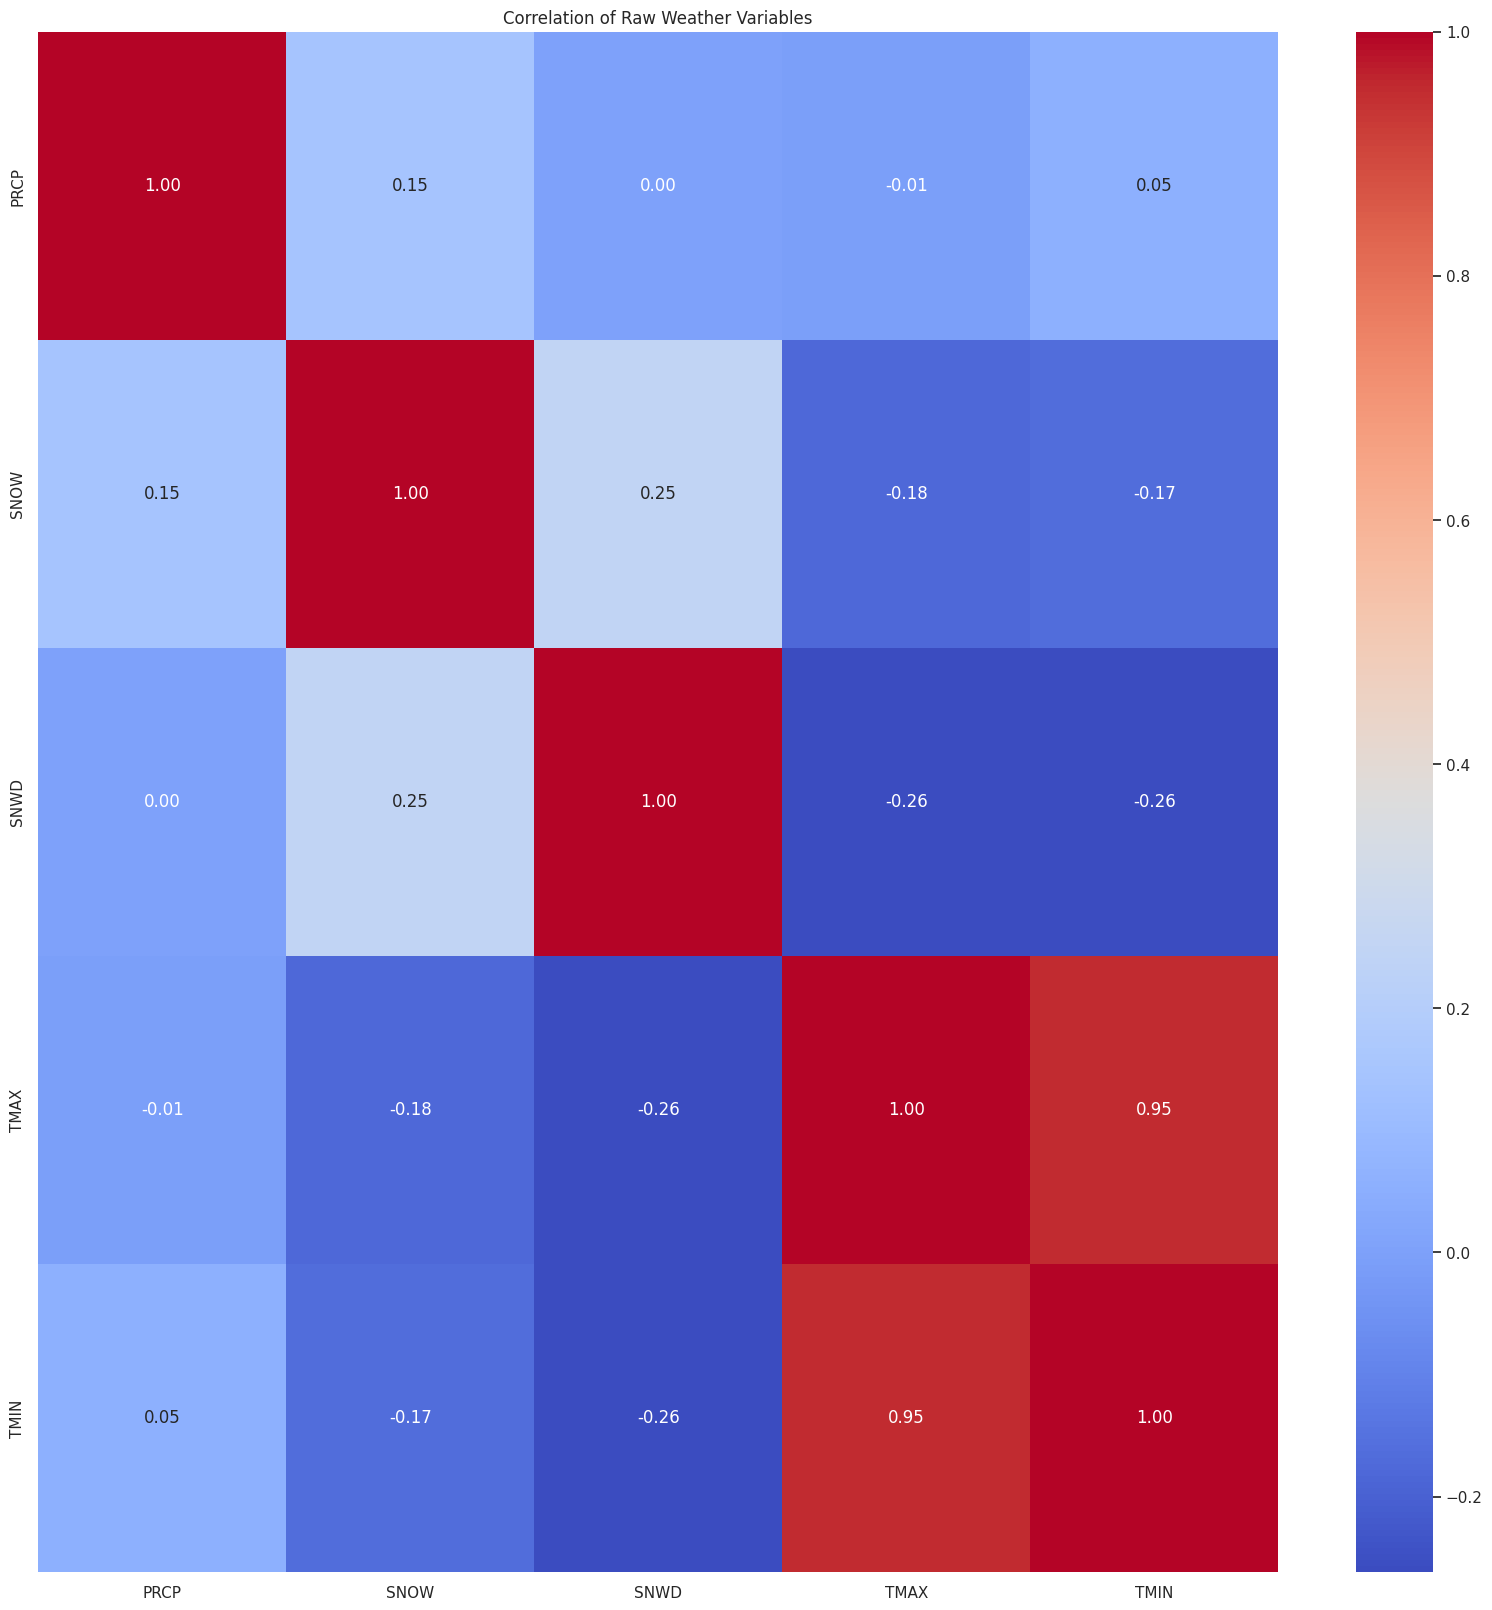

In [8]:
cols_to_check = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

# Calculate correlation
corr_matrix = df[cols_to_check].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Raw Weather Variables')
plt.show()


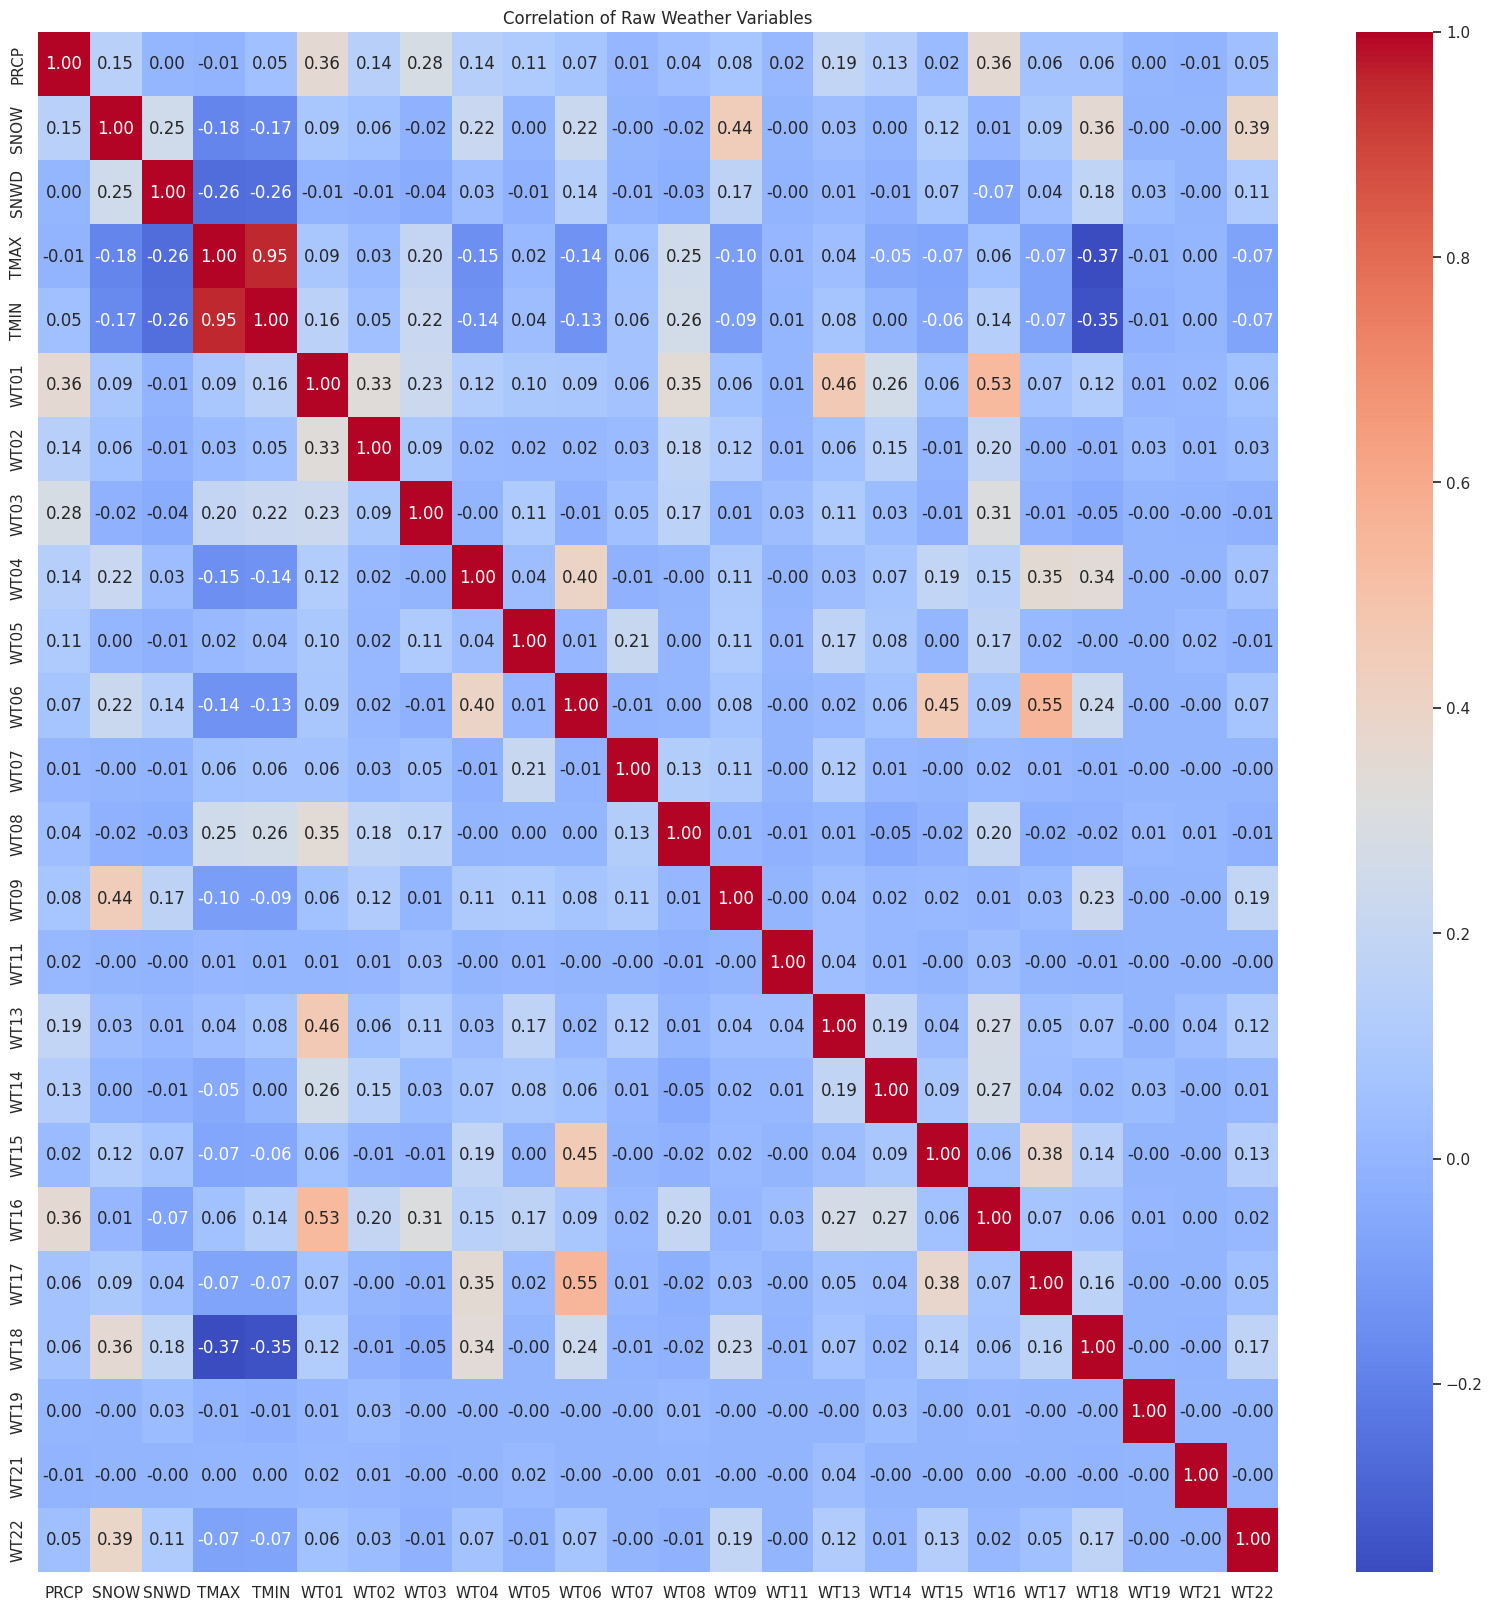

In [9]:
cols_to_check = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']+ wt_cols

# Calculate correlation
corr_matrix = df[cols_to_check].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Raw Weather Variables')
plt.show()


Setup normalized linear regression :)

In [12]:
# 1. Sort to ensure time alignment
df = df.sort_values('DATE')

# 2. Create "Lagged" Features (Yesterday's Data)
# We use Yesterday's Low, High, and Precip to predict Today's High
df['TMIN_yesterday'] = df['TMIN'].shift(1)
df['TMAX_yesterday'] = df['TMAX'].shift(1)
df['PRCP_yesterday'] = df['PRCP'].shift(1)
df['SNOW_yesterday'] = df['SNOW'].shift(1)
df['SNWD_yesterday'] = df['SNWD'].shift(1)

# 3. Define Features (Note: We removed the raw 'TMIN' column)
feature_cols = ['TMIN_yesterday', 'TMAX_yesterday', 'PRCP_yesterday', 'SNOW_yesterday', 'SNWD_yesterday']

# 4. Drop the first row (which now has NaNs due to shifting)
df_clean = df.dropna(subset=feature_cols + ['TMAX']).copy()

X = df_clean[feature_cols].copy()
y = df_clean['TMAX'].copy()

# 5. Create Splits (Manual Time Split)
split_index = int(len(df_clean) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

In [13]:
# Perform (ridge) regression with cross-validation to find the best alpha
alphas = np.linspace(0.1, 100.0, 100)
ridge_model = RidgeCV(alphas=alphas, scoring='neg_median_absolute_error', cv=10)
ridge_model.fit(X_train, y_train)

p = ridge_model.alpha_
print('Best alpha:', p)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)
ridge_mae = mean_absolute_error(y_test, y_pred)
print('Ridge MAE:', ridge_mae)

Best alpha: 12.209090909090909
Ridge MAE: 5.001115580241021


In [14]:
def predict_temperature_baseline(input_features, model):
    """
    Takes features and a model, returns predicted TMIN and TMAX.
    """
    prediction = model.predict(input_features)
    return {
        'Predicted_TMAX': prediction
    }

In [39]:
random_index = np.random.randint(0, len(X_test))
print(predict_temperature_baseline(X_test.iloc[[random_index]], ridge_model))
print(y_test.iloc[random_index])

{'Predicted_TMAX': array([82.64820021])}
88.0


Now let's see how the baseline does visually !!!

<Figure size 700x700 with 0 Axes>

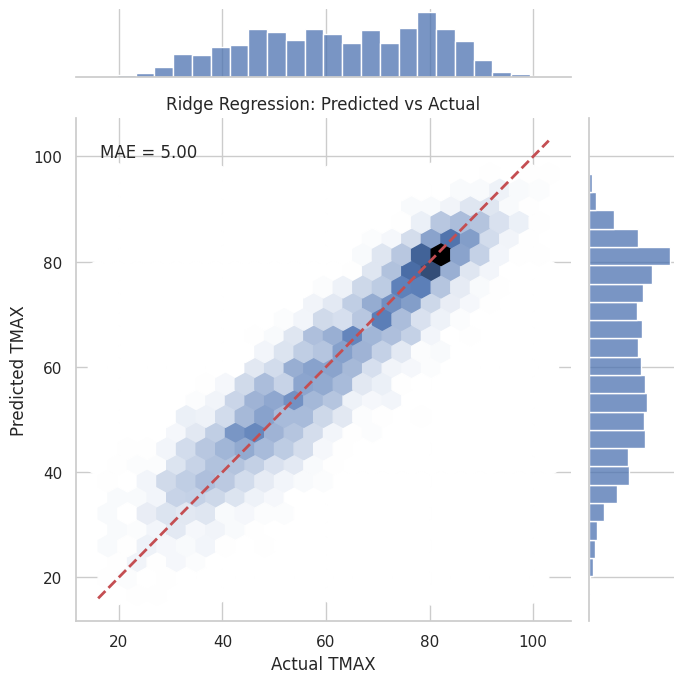

In [40]:
plot_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

sns.set(style="whitegrid")

plt.figure(figsize=(7, 7))
sns.jointplot(
    data=plot_df,
    x="Actual",
    y="Predicted",
    kind="hex",
    height=7
)

# 45-degree reference line (perfect predictions)
min_val = min(plot_df.min())
max_val = max(plot_df.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel("Actual TMAX")
plt.ylabel("Predicted TMAX")
plt.title("Ridge Regression: Predicted vs Actual")

plt.tight_layout()
plt.text(
    0.05, 0.95,
    f"MAE = {ridge_mae:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top"
)
plt.show()

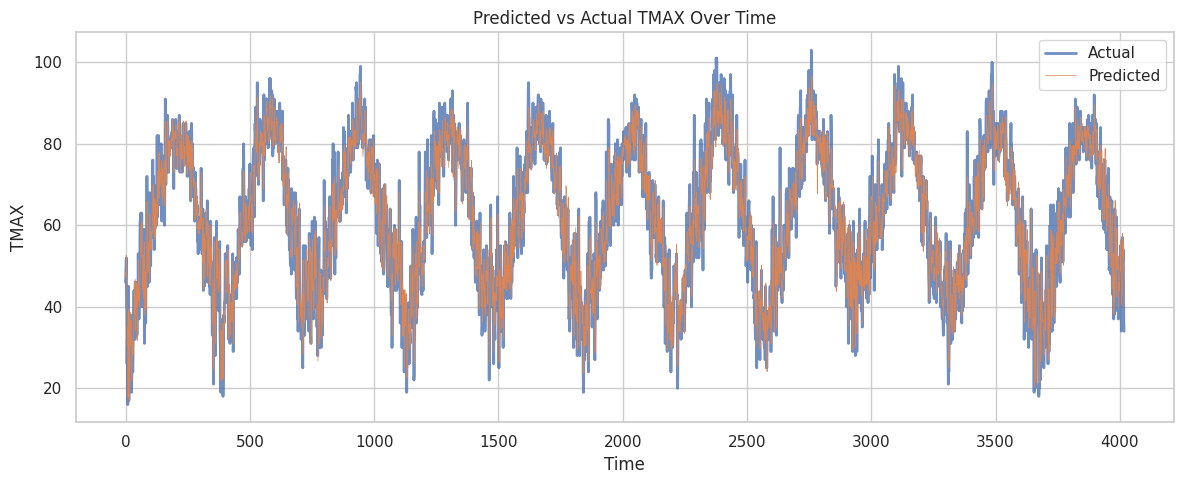

In [41]:
plot_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

plt.figure(figsize=(12, 5))

plt.plot(plot_df.index, plot_df["Actual"], label="Actual", linewidth=2, alpha=0.8)
plt.plot(plot_df.index, plot_df["Predicted"], label="Predicted", linewidth=0.5, alpha=1)

plt.xlabel("Time")
plt.ylabel("TMAX")
plt.title("Predicted vs Actual TMAX Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²   = {r2:.3f}")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape*100:.2f}%")

bias = np.mean(y_pred - y_test)
print(f"Bias = {bias:.2f}")

baseline = np.mean(y_test)
baseline_pred = np.full_like(y_test, baseline)

R²   = 0.864
MAE  = 5.00
RMSE = 6.44
MAPE = 9.31%
Bias = -0.12


In [43]:
baseline = np.mean(y_train)
baseline_pred = np.full_like(y_test, baseline)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(baseline_mae)

15.01661124813882


In [44]:
monthly_clim = (
    df.loc[y_train.index]
      .groupby('month_name')['TMAX']
      .mean()
)

baseline_pred_monthly = (
    df.loc[y_test.index, 'month_name']
      .map(monthly_clim)
)

monthly_baseline_mae = mean_absolute_error(y_test, baseline_pred_monthly)
print(monthly_baseline_mae)

6.11930047982553


Over the years weather events may have become more volatile and this would affect the model performance and give unrealistic confidence in our predictions. To test if this is the case let's use the Breusch-Pagan test for heteroskedasticity. 

But we have to be careful since we have quite a bit of data and this test is known for overestimating effects when there's a large sample set. So let's see visually what's going on!

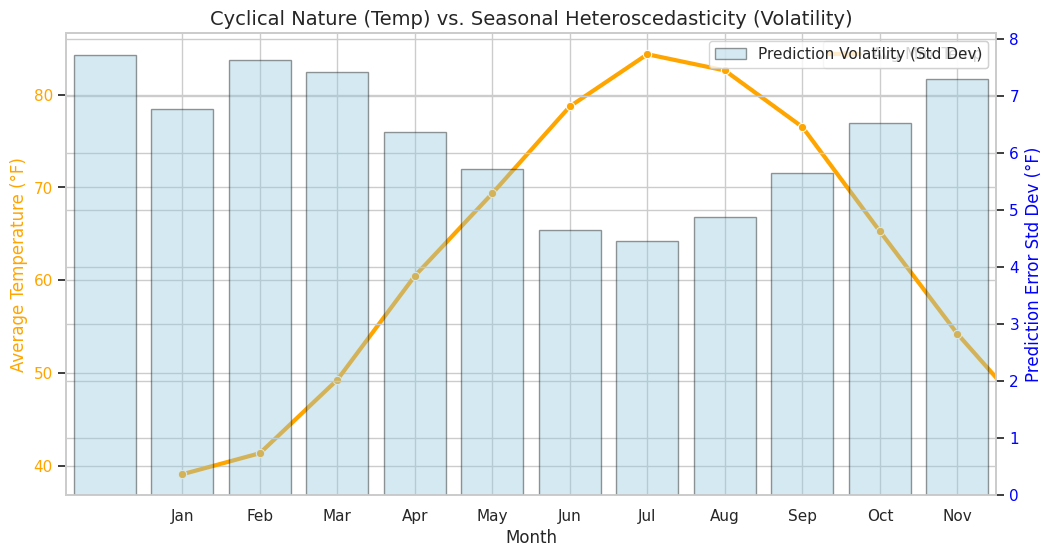

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data for evaluation
results = pd.DataFrame({
    'Date': df.loc[y_test.index, 'DATE'],
    'Actual_TMAX': y_test,
    'Residuals': y_test - ridge_model.predict(X_test) # Or use your specific model predictions
})

results['Month'] = results['Date'].dt.month

# Calculate Metrics per Month
monthly_stats = results.groupby('Month').agg({
    'Actual_TMAX': 'mean',          # The "Cyclical Nature" (Temperature)
    'Residuals': 'std'              # The "Heteroscedasticity" (Uncertainty)
})

# 3. Plot with Dual Axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Temperature (The Cycle)
sns.lineplot(data=monthly_stats, x=monthly_stats.index, y='Actual_TMAX', 
             ax=ax1, color='orange', marker='o', linewidth=3, label='Avg Max Temp')
ax1.set_ylabel('Average Temperature (°F)', color='orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_xlabel('Month')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Create a second y-axis for Volatility
ax2 = ax1.twinx()
sns.barplot(data=monthly_stats, x=monthly_stats.index, y='Residuals', 
            ax=ax2, color='skyblue', alpha=0.4, edgecolor='black', label='Prediction Volatility (Std Dev)')
ax2.set_ylabel('Prediction Error Std Dev (°F)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Title and Legend
plt.title('Cyclical Nature (Temp) vs. Seasonal Heteroscedasticity (Volatility)', fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()

plt.show()

In [46]:
# Prepare data for Breusch-Pagan test
X_test_with_const = sm.add_constant(X_test)
residuals = y_test - y_pred

# Perform the test for heteroscedasticity
lm, p_lm, fvalue, p_fvalue = het_breuschpagan(residuals, X_test_with_const)

print(f"Lagrange Multiplier statistic: {lm:.4f}")
print(f"P-value: {p_lm:.4e}")

if p_lm < 0.05:
    print("Result: Heteroscedasticity detected! (Variance is changing)")
else:
    print("Result: Homoscedasticity assumed (Variance is constant)")

Lagrange Multiplier statistic: 360.5026
P-value: 9.5860e-76
Result: Heteroscedasticity detected! (Variance is changing)


Let's try a stronger model (XGBoostRegression) with quantiles that can account for this seasonal volatility:

Through feature engineering I found that:
- Cyclical fetures like dates inputs and angles are better represented by sinusoidal features.
- Including southern winds bring warmer temperatures and we can leverage this!
- We have to backfill some wind data to the 60's because it wasn't available until the 2000's. 

[I 2026-01-17 15:11:32,537] A new study created in memory with name: no-name-c8d32670-86db-44c1-9b64-dc8f9822b351


STRICT MODE: Predicting Tomorrow's High using ONLY Yesterday's data.
Training on 16068 rows.
Tuning hyperparameters...


[I 2026-01-17 15:11:36,214] Trial 0 finished with value: 4.2523987505672105 and parameters: {'n_estimators': 684, 'max_depth': 3, 'learning_rate': 0.01789136985819759, 'subsample': 0.877802034522523, 'colsample_bytree': 0.720940668283268, 'reg_alpha': 4.406604407963951, 'reg_lambda': 4.99489579879281}. Best is trial 0 with value: 4.2523987505672105.
[I 2026-01-17 15:11:38,879] Trial 1 finished with value: 4.200036748123739 and parameters: {'n_estimators': 422, 'max_depth': 7, 'learning_rate': 0.12157674622019217, 'subsample': 0.8677160107651773, 'colsample_bytree': 0.8207697942958724, 'reg_alpha': 6.083298234782565, 'reg_lambda': 2.2334407080587813}. Best is trial 1 with value: 4.200036748123739.
[I 2026-01-17 15:11:41,350] Trial 2 finished with value: 4.3350687724788015 and parameters: {'n_estimators': 575, 'max_depth': 8, 'learning_rate': 0.13137890430019059, 'subsample': 0.7372392578876241, 'colsample_bytree': 0.6107344566307245, 'reg_alpha': 4.645079885147213, 'reg_lambda': 8.49094

Best MAE: 4.1007

FINAL TEST MAE: 4.1007 °F


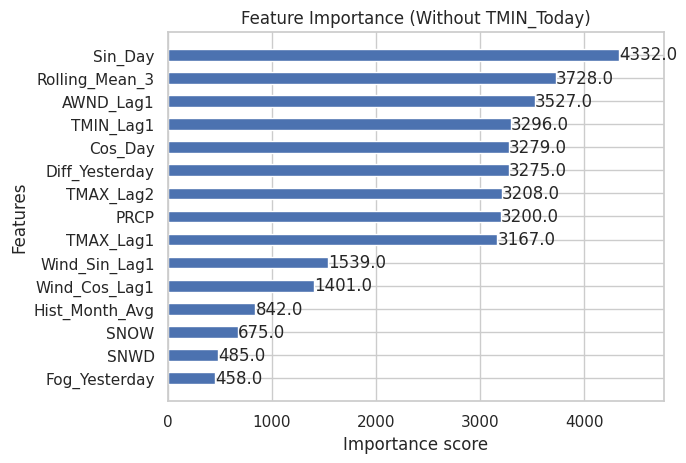

In [48]:
# ==============================================================================
# 1. LOAD & CLEAN DATA
# ==============================================================================
df = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])
df = df[df['NAME'].str.contains('JFK')].copy().sort_values('DATE')

# Select only the columns we determined are useful
useful_cols = [
    'DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', # Core
    'AWND', 'WDF2',                                 # Wind
    'WT01', 'WT03', 'WT08', 'WT18'                  # Fog, Thunder, Haze, Snow
]
df = df[useful_cols].copy()

# Fix numeric columns
cols_to_numeric = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Basic fill for core weather (persistence)
df[cols_to_numeric] = df[cols_to_numeric].ffill().bfill()

# ==============================================================================
# 2. WIND ENGINEERING & BACKFILLING (The "Time Machine")
# ==============================================================================
# A. Convert Degrees to Vectors
df['Wind_Rad'] = df['WDF2'] * np.pi / 180
df['Wind_Sin'] = np.sin(df['Wind_Rad'])
df['Wind_Cos'] = np.cos(df['Wind_Rad'])

# B. Create Climatology from modern data (2000-2014)
df['DayOfYear'] = df['DATE'].dt.dayofyear
modern_data = df[df['DATE'].dt.year >= 2000]
wind_climatology = modern_data.groupby('DayOfYear')[['Wind_Sin', 'Wind_Cos', 'AWND']].mean()

# C. Fill missing past (1960-1999) using the Climatology
for col in ['Wind_Sin', 'Wind_Cos', 'AWND']:
    fill_values = df['DayOfYear'].map(wind_climatology[col])
    df[col] = df[col].fillna(fill_values)

# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================
# A. Weather Types (WT)
wt_cols = ['WT01', 'WT03', 'WT08', 'WT18']
df[wt_cols] = df[wt_cols].fillna(0)

df['Fog_Yesterday'] = df['WT01'].shift(1)
df['Thunder_Yesterday'] = df['WT03'].shift(1)
df['Haze_Yesterday'] = df['WT08'].shift(1)
df['Snow_Event_Yesterday'] = df['WT18'].shift(1)

# B. Wind Lags
df['Wind_Sin_Lag1'] = df['Wind_Sin'].shift(1)
df['Wind_Cos_Lag1'] = df['Wind_Cos'].shift(1)
df['AWND_Lag1'] = df['AWND'].shift(1)

# C. Temperature Lags & Trends
df['TMAX_Lag1'] = df['TMAX'].shift(1)
df['TMAX_Lag2'] = df['TMAX'].shift(2)
df['TMIN_Lag1'] = df['TMIN'].shift(1) # We know Yesterday's Min, just not Today's
df['Rolling_Mean_3'] = df['TMAX'].shift(1).rolling(window=3).mean()
df['Diff_Yesterday'] = df['TMAX'].shift(1) - df['TMIN'].shift(1)

# D. Cyclical Time
df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['Month'] = df['DATE'].dt.month

# ==============================================================================
# 4. SPLIT & HISTORICAL AVERAGES
# ==============================================================================
features = [
    'TMAX_Lag1', 'TMAX_Lag2', 'TMIN_Lag1',
    'Rolling_Mean_3', 'Diff_Yesterday',
    'Wind_Sin_Lag1', 'Wind_Cos_Lag1', 'AWND_Lag1',
    'Fog_Yesterday', 'Thunder_Yesterday', 'Haze_Yesterday', 'Snow_Event_Yesterday',
    'Sin_Day', 'Cos_Day', 'Hist_Month_Avg',
    'PRCP', 'SNOW', 'SNWD'
]
# REMOVED: 'TMIN_Today' is GONE.

df_clean = df.dropna(subset=[f for f in features if f != 'Hist_Month_Avg'] + ['TMAX']).copy()

# Split Indices
split_point = int(len(df_clean) * 0.8)

# Calculate Historical Averages (Train Set Only)
train_df = df_clean.iloc[:split_point]
monthly_avgs = train_df.groupby('Month')['TMAX'].mean().to_dict()
df_clean['Hist_Month_Avg'] = df_clean['Month'].map(monthly_avgs)

X = df_clean[features]
y = df_clean['TMAX']

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"STRICT MODE: Predicting Tomorrow's High using ONLY Yesterday's data.")
print(f"Training on {len(X_train)} rows.")

# ==============================================================================
# 5. OPTUNA TUNING
# ==============================================================================
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:absoluteerror',
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train) 
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

print("Tuning hyperparameters...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) 

print(f"Best MAE: {study.best_value:.4f}")

# ==============================================================================
# 6. FINAL TRAINING
# ==============================================================================
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params, objective='reg:absoluteerror', n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)

final_preds = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_preds)

print(f"\nFINAL TEST MAE: {final_mae:.4f} °F")

# Feature Importance
xgb.plot_importance(final_model, max_num_features=15, height=0.5)
plt.title("Feature Importance (Without TMIN_Today)")
plt.show()

In [ ]:
print(study.best_params)
# {'n_estimators': 848,
#  'max_depth': 6,
#  'learning_rate': 0.02134633366334265,
#  'subsample': 0.7522575963360201,
#  'colsample_bytree': 0.7453138233240533,
#  'reg_alpha': 9.927792069480603,
#  'reg_lambda': 8.659132531134576}

{'n_estimators': 848, 'max_depth': 6, 'learning_rate': 0.02134633366334265, 'subsample': 0.7522575963360201, 'colsample_bytree': 0.7453138233240533, 'reg_alpha': 9.927792069480603, 'reg_lambda': 8.659132531134576}


Training Final Volatility-Aware Tunnel...
{'n_estimators': 848, 'max_depth': 6, 'learning_rate': 0.02134633366334265, 'subsample': 0.7522575963360201, 'colsample_bytree': 0.7453138233240533, 'reg_alpha': 9.927792069480603, 'reg_lambda': 8.659132531134576}


<Figure size 1000x500 with 0 Axes>

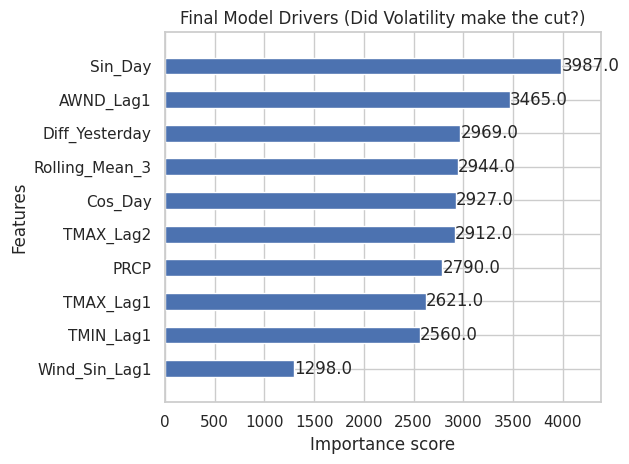

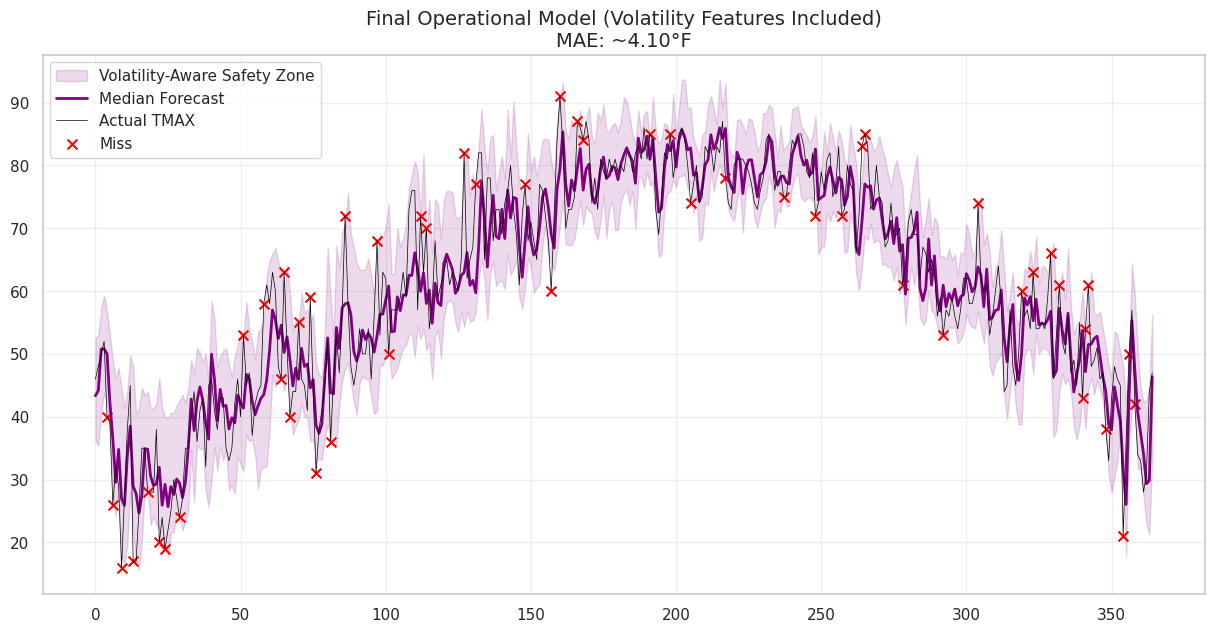

In [50]:
print("Training Final Volatility-Aware Tunnel...")
q_params = study.best_params.copy()
print(q_params)
q_params['objective'] = 'reg:quantileerror'
q_params['n_estimators'] = 888

m_low  = xgb.XGBRegressor(**q_params, quantile_alpha=0.05).fit(X_train, y_train)
m_mid  = xgb.XGBRegressor(**q_params, quantile_alpha=0.50).fit(X_train, y_train)
m_high = xgb.XGBRegressor(**q_params, quantile_alpha=0.95).fit(X_train, y_train)

# 2. Predict
p_low  = m_low.predict(X_test)
p_mid  = m_mid.predict(X_test)
p_high = m_high.predict(X_test)

# 3. Plot Feature Importance (Did it use the new features?)
plt.figure(figsize=(10, 5))
xgb.plot_importance(m_mid, max_num_features=10, height=0.5, 
                   title="Final Model Drivers (Did Volatility make the cut?)", 
                   importance_type='weight')
plt.tight_layout()
plt.show()

# 4. Plot The Final Tunnel
plt.figure(figsize=(15, 7))
subset = 365
dates_plot = range(subset)

# Plot the Tunnel
plt.fill_between(dates_plot, p_low[:subset], p_high[:subset], color='purple', alpha=0.15, label='Volatility-Aware Safety Zone')
plt.plot(dates_plot, p_mid[:subset], color='purple', linewidth=2, label='Median Forecast')
plt.plot(dates_plot, y_test.iloc[:subset], color='black', label='Actual TMAX', linewidth=0.5)

# Highlight Misses
actuals = y_test.iloc[:subset].values
mask = (actuals < p_low[:subset]) | (actuals > p_high[:subset])
plt.scatter(np.array(dates_plot)[mask], actuals[mask], color='red', marker='x', s=50, label='Miss')

plt.title(f'Final Operational Model (Volatility Features Included)\nMAE: ~{final_mae:.2f}°F', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


------------------------------------------------
TOP 20 WORST PREDICTIONS (The Model's Nightmares)
------------------------------------------------
      Date  Actual_TMIN  Predicted_TMIN     Error  TMIN_Lag1
2011-03-18         79.0       56.357574 22.642426       45.0
2009-03-07         68.0       45.875134 22.124866       36.0
2007-03-27         78.0       56.879944 21.120056       36.0
2013-04-09         83.0       62.989346 20.010654       42.0
2010-04-07         87.0       67.047089 19.952911       51.0
2007-04-30         81.0       61.316166 19.683834       51.0
2007-01-06         71.0       51.465725 19.534275       46.0
2009-04-26         86.0       66.692886 19.307114       49.0
2014-03-08         60.0       40.745022 19.254978       27.0
2004-05-07         82.0       62.975246 19.024754       49.0
2006-01-30         62.0       43.647846 18.352154       34.0
2011-07-22        103.0       84.837624 18.162376       73.0
2006-04-15         80.0       62.028126 17.971874       49

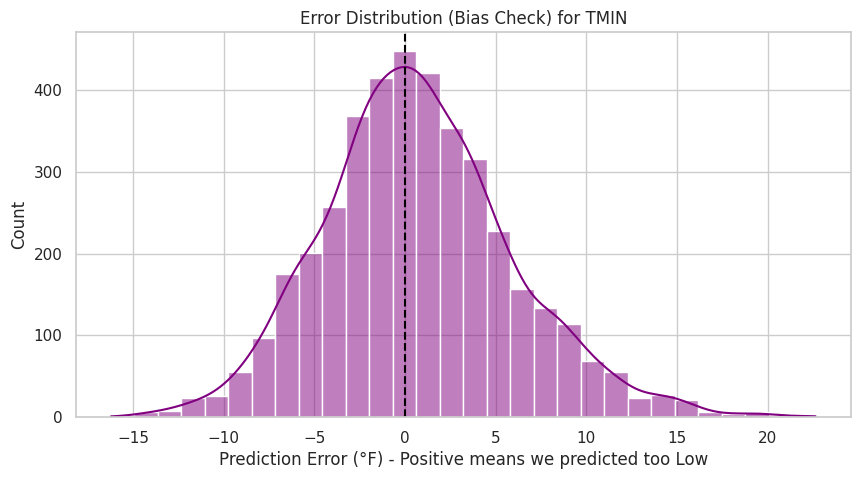

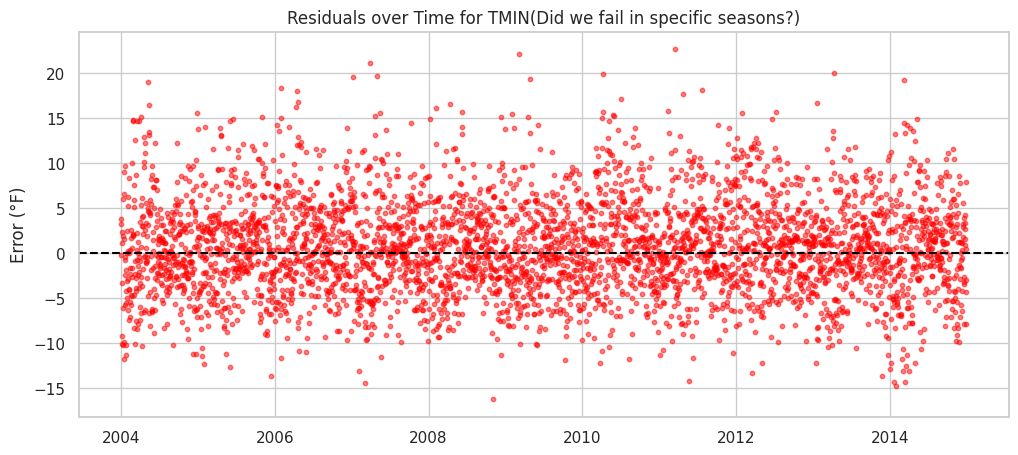


------------------------------------------------
TOP 20 WORST PREDICTIONS (The Model's Nightmares)
------------------------------------------------
      Date  Actual_TMAX  Predicted_TMAX     Error  TMAX_Lag1
2011-03-18         79.0       56.357574 22.642426       62.0
2009-03-07         68.0       45.875134 22.124866       45.0
2007-03-27         78.0       56.879944 21.120056       48.0
2013-04-09         83.0       62.989346 20.010654       68.0
2010-04-07         87.0       67.047089 19.952911       73.0
2007-04-30         81.0       61.316166 19.683834       68.0
2007-01-06         71.0       51.465725 19.534275       56.0
2009-04-26         86.0       66.692886 19.307114       69.0
2014-03-08         60.0       40.745022 19.254978       36.0
2004-05-07         82.0       62.975246 19.024754       65.0
2006-01-30         62.0       43.647846 18.352154       47.0
2011-07-22        103.0       84.837624 18.162376       88.0
2006-04-15         80.0       62.028126 17.971874       59

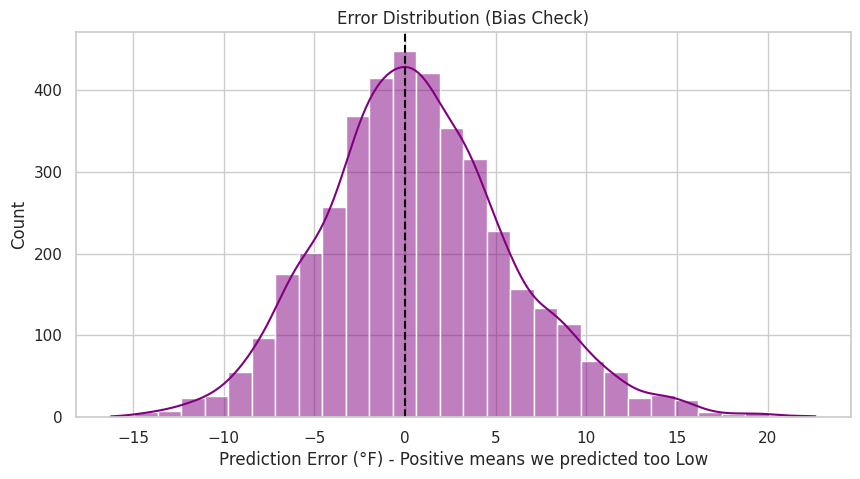

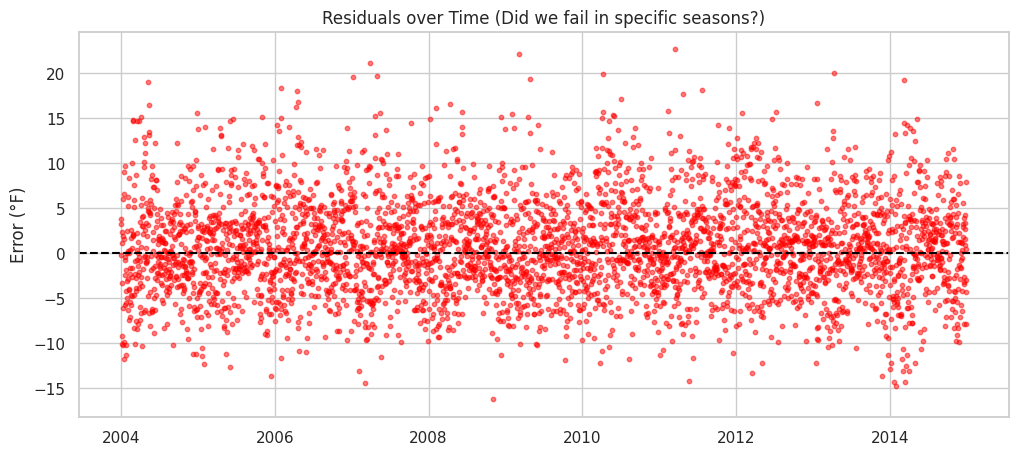

In [52]:
# ==============================================================================
# 7. FORENSIC ANALYSIS: When did the model fail?
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate Predictions (if you haven't already)
final_model = xgb.XGBRegressor(**study.best_params, objective='reg:absoluteerror', n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

# 2. Create a DataFrame of failures
errors = X_test.copy()
errors['Actual_TMIN'] = y_test
errors['Predicted_TMIN'] = final_preds
errors['Error'] = errors['Actual_TMIN'] - errors['Predicted_TMIN']
errors['Abs_Error'] = errors['Error'].abs()
errors['Date'] = df.loc[errors.index, 'DATE'] # Map back to dates

# 3. Sort by biggest failures
worst_days = errors.sort_values('Abs_Error', ascending=False).head(20)

print("\n------------------------------------------------")
print("TOP 20 WORST PREDICTIONS (The Model's Nightmares)")
print("------------------------------------------------")
# We display TMIN_Lag1 because knowing yesterday's low is crucial for today's low
cols_to_show = ['Date', 'Actual_TMIN', 'Predicted_TMIN', 'Error', 'TMIN_Lag1']
print(worst_days[cols_to_show].to_string(index=False))

# 4. Visualization: Error Distribution
plt.figure(figsize=(10, 5))
# Fixed: bins=30 (bins=0 causes a crash)
sns.histplot(errors['Error'], bins=30, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Error Distribution (Bias Check) for TMIN")
plt.xlabel("Prediction Error (°F) - Positive means we predicted too Low")
plt.show()

# 5. Visualization: Time Series of Errors
plt.figure(figsize=(12, 5))
plt.scatter(errors['Date'], errors['Error'], alpha=0.5, color='red', s=10)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals over Time for TMIN(Did we fail in specific seasons?)")
plt.ylabel("Error (°F)")
plt.show()# ==============================================================================
# 7. FORENSIC ANALYSIS: When did the model fail?
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate Predictions (if you haven't already)
final_model = xgb.XGBRegressor(**study.best_params, objective='reg:absoluteerror', n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

# 2. Create a DataFrame of failures
errors = X_test.copy()
errors['Actual_TMAX'] = y_test
errors['Predicted_TMAX'] = final_preds
errors['Error'] = errors['Actual_TMAX'] - errors['Predicted_TMAX']
errors['Abs_Error'] = errors['Error'].abs()
errors['Date'] = df.loc[errors.index, 'DATE'] # Map back to dates

# 3. Sort by biggest failures
worst_days = errors.sort_values('Abs_Error', ascending=False).head(20)

print("\n------------------------------------------------")
print("TOP 20 WORST PREDICTIONS (The Model's Nightmares)")
print("------------------------------------------------")
# We display TMAX_Lag1 because knowing yesterday's low is crucial for today's low
cols_to_show = ['Date', 'Actual_TMAX', 'Predicted_TMAX', 'Error', 'TMAX_Lag1']
print(worst_days[cols_to_show].to_string(index=False))

# 4. Visualization: Error Distribution
plt.figure(figsize=(10, 5))
# Fixed: bins=30 (bins=0 causes a crash)
sns.histplot(errors['Error'], bins=30, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Error Distribution (Bias Check)")
plt.xlabel("Prediction Error (°F) - Positive means we predicted too Low")
plt.show()

# 5. Visualization: Time Series of Errors
plt.figure(figsize=(12, 5))
plt.scatter(errors['Date'], errors['Error'], alpha=0.5, color='red', s=10)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals over Time (Did we fail in specific seasons?)")
plt.ylabel("Error (°F)")
plt.show()